In [1]:
import numpy as np

In [2]:
import torch
import matplotlib.pyplot as plt

In [3]:
import torch.nn as nn

In [4]:
#Define the input
inputs = np.expand_dims(np.arange(-1.5, 1.5, 0.01),1)

#We'll be using sinc() function to generate output
outputs = np.sinc(5*inputs)

In [6]:
# Shape of x and y
print(inputs.shape)
print(outputs.shape)

(300, 1)
(300, 1)


In [7]:
# Convert np arr to tensors
input_tensor = torch.tensor(inputs, dtype=torch.float32)
output_tensor = torch.tensor(outputs, dtype=torch.float32)

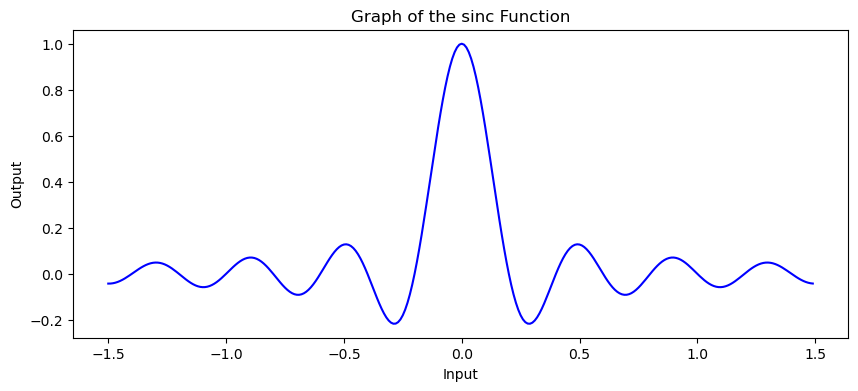

In [8]:
# Graph for the function
plt.figure(figsize=(10,4))
plt.plot(input_tensor, output_tensor, color = "blue")
plt.title('Graph of the sinc Function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

In [9]:
class SincModel(nn.Module):
    def __init__(self):
        super(SincModel, self).__init__()
        self.linear_1 = nn.Linear(1, 4)
        self.linear_2 = nn.Linear(4, 9)
        self.linear_3 = nn.Linear(9, 12)
        self.linear_4 = nn.Linear(12, 10)
        self.linear_5 = nn.Linear(10, 10)
        self.linear_6 = nn.Linear(10, 10)
        self.linear_7 = nn.Linear(10, 4)
        self.predict = nn.Linear(4, 1)
    
    def forward(self,input_tensor):
        input_tensor = nn.functional.leaky_relu(self.linear_1(input_tensor))
        input_tensor = nn.functional.leaky_relu(self.linear_2(input_tensor))
        input_tensor = nn.functional.leaky_relu(self.linear_3(input_tensor))
        input_tensor = nn.functional.leaky_relu(self.linear_4(input_tensor))
        input_tensor = nn.functional.leaky_relu(self.linear_5(input_tensor))
        input_tensor = nn.functional.leaky_relu(self.linear_6(input_tensor))
        input_tensor = nn.functional.leaky_relu(self.linear_7(input_tensor))

        input_tensor = self.predict(input_tensor)
        return input_tensor

In [10]:
model = SincModel()
total_parameters = sum(param.numel() for param in model.parameters())
print('Total number of parameters:', total_parameters)

Total number of parameters: 572


In [14]:
def train_sinc_model(model, input_tensor, output_tensor):
    epoch_size = 4000
    loss_arr = []
    epoch_arr = []
    grad_arr = []
    converged = False
    min_grad = 0
    loss_val = 0
    print('Beginning training')
    
    for epoch in range(epoch_size):
        if converged:
            return epoch_arr, loss_arr, y_prediction, grad_arr

        y_prediction = model(input_tensor)
        lossm_val = 0.001
        loss = loss_func(y_prediction, output_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_arr.append(epoch)
        loss_arr.append(loss.detach().numpy())
        
        # Calculate the gradient
        grad_all = 0.0
        for param in model.parameters():
            grad = 0.0
            if param.grad is not None:
                grad = (param.grad.cpu().data.numpy() ** 2).sum()
            grad_all += grad
        grad_norm = grad_all ** 0.5
        
        grad_arr.append(grad_norm)
        
        total_parameters = sum(param.numel() for param in model.parameters())
        if grad_norm < 0.001 or epoch == epoch_size:
            print('Gradient norm reached minimum value')
            predicted_y = model(input_tensor)
            lossm = loss_func(predicted_y, output_tensor)
            H = torch.zeros((total_parameters, total_parameters))

            Jacob = torch.autograd.grad(lossm, list(model.parameters()), create_graph=True)
            Jacob = torch.cat([e.flatten() for e in Jacob])  # flatten
            for i in range(total_parameters):
                result = torch.autograd.grad(Jacob[i], list(model.parameters()), retain_graph=True)
                H[i] = torch.cat([r.flatten() for r in result])  # flatten
            
            # Update eigenvalue calculation
            H_eig = torch.linalg.eigvalsh(H)
            positive_count = 0
            for i in H_eig.tolist():
                if i > 0:
                    positive_count += 1
            minimal_ratio = positive_count / H.shape[0]
            print('Minimal Ratio - ', minimal_ratio, ' , Loss - ', lossm.data.detach().numpy(), ' Epoch - ', epoch)
            lossm_val = lossm.data.detach().numpy()
            break
                
    print('Training Completed')
    return lossm_val, minimal_ratio

In [15]:
loss_arr = []
min_ratio_arr = []
for index in range(100):
    print("Training model ", index)
    model = SincModel()
    loss_func = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

    loss_value, min_ratio = train_sinc_model(model, input_tensor, output_tensor)
    loss_arr.append(loss_value)
    min_ratio_arr.append(min_ratio)

Training model  0
Beginning training
Gradient norm reached minimum value
Minimal Ratio -  0.5437062937062938  , Loss -  0.0012374166  Epoch -  1352
Training Completed
Training model  1
Beginning training
Gradient norm reached minimum value
Minimal Ratio -  0.5384615384615384  , Loss -  0.0017352318  Epoch -  2286
Training Completed
Training model  2
Beginning training
Gradient norm reached minimum value
Minimal Ratio -  0.5052447552447552  , Loss -  0.061255075  Epoch -  75
Training Completed
Training model  3
Beginning training
Gradient norm reached minimum value
Minimal Ratio -  0.5244755244755245  , Loss -  0.0036047304  Epoch -  1191
Training Completed
Training model  4
Beginning training
Gradient norm reached minimum value
Minimal Ratio -  0.5244755244755245  , Loss -  0.003293416  Epoch -  1269
Training Completed
Training model  5
Beginning training
Gradient norm reached minimum value
Minimal Ratio -  0.5157342657342657  , Loss -  0.005421075  Epoch -  1066
Training Completed
Tra

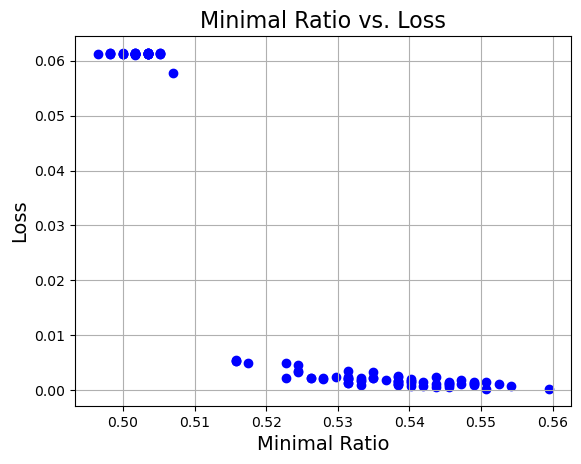

In [16]:
plt.scatter(min_ratio_arr,loss_arr, color = "blue")
plt.xlabel("Minimal Ratio", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Minimal Ratio vs. Loss", fontsize=16)
plt.grid(True)
plt.show()